In [2]:
# Общие библиотеки
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Статистические библиотеки
from scipy.stats import norm, anderson, shapiro, kstest, chi2

# Модели и алгоритмы
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import math

# Добавляем путь к репозиторию
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(repo_root)
# Собственные модули
from src.utils import CIFAR
from src.model import CIFAR_CNN

In [4]:
import numpy as np
import scipy.stats as st

def sample_alpha_stable(alpha, sigma, size):
    """
    Генерирует выборку из SαS(σ) распределения с заданным α, σ и размером выборки.
    """
    return st.levy_stable.rvs(alpha, 0, scale=sigma, size=size)

def estimate_alpha(X, K1, K2):
    """
    Оценка параметра α с использованием метода из статьи.
    """
    K = K1 * K2
    Y = [sum(X[j + (i - 1) * K1] for j in range(K1)) for i in range(1, K2 + 1)]
    
    term1 = np.mean(np.log(np.abs(Y)))
    term2 = np.mean(np.log(np.abs(X)))
    
    alpha_est = (term1 - term2) ** -1
    return alpha_est

# Параметры
true_alpha = 1.2
sigma = 1  # Масштабный параметр
K1, K2 = 100, 1000  # Параметры разбиения выборки
size = K1 * K2

# Генерация данных
X = sample_alpha_stable(true_alpha, sigma, size)

# Оценка α
estimated_alpha = estimate_alpha(X, K1, K2)

# Вывод результатов
print(f"Истинное α: {true_alpha}")
print(f"Оценённое α: {estimated_alpha:.4f}")

Истинное α: 1.2
Оценённое α: 0.2625


In [4]:
def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)


def stochastic_gradient_sampling(model, optimizer, train_loader, criterion, device, stat_function, seed=42):
    # Установка сидов для повторяемости результатов
    set_seeds(seed)
    
    model.train()
    full_gradients = {name: 0 for name, param in model.named_parameters()}
    
    # Первый цикл: вычисляем полные градиенты (усредненные по батчам)
    for images, labels in tqdm(train_loader, desc="Computing full gradients"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        for name, param in model.named_parameters():
            full_gradients[name] += param.grad
    
    # Усредняем полные градиенты по количеству батчей
    for name in full_gradients:
        full_gradients[name] /= len(train_loader)
    
    # Второй цикл: вычисляем разности с полными градиентами и сохраняем 2-норму
    gradients_diff = []
    for images, labels in tqdm(train_loader, desc="Computing gradient differences"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Для каждого батча считаем разницу в норме между полными и стохастическими градиентами
        gradient_diff = {name: full_gradients[name] - param.grad for name, param in model.named_parameters()}

        # Вызываем stat_function для вычисления статистики
        gradient_stat = stat_function(gradient_diff, model, device=device)
        # print(gradient_stat)    
        gradients_diff.append(gradient_stat)
    
    return gradients_diff


In [5]:
DEVICE = "mps"

# Папка с чекпоинтами
CHECKPOINT_DIR = f"{repo_root}/data/checkpoints/exp6"


In [6]:
checkpoint_files = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')]

# Список для хранения моделей
models = []

# Загружаем модели
for checkpoint_file in checkpoint_files:
    checkpoint_path = os.path.join(CHECKPOINT_DIR, checkpoint_file)
    
    # Создаём экземпляр модели
    model = CIFAR_CNN().to(DEVICE)
    
    # Загружаем веса модели
    model.load_state_dict(torch.load(checkpoint_path))
    
    # Добавляем модель в список
    models.append(model)
    print(f"Model loaded from {checkpoint_path}")

Model loaded from /Users/igoreshka/Desktop/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_20.pth
Model loaded from /Users/igoreshka/Desktop/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_4.pth
Model loaded from /Users/igoreshka/Desktop/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_8.pth
Model loaded from /Users/igoreshka/Desktop/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_16.pth
Model loaded from /Users/igoreshka/Desktop/SGDiffusion/data/checkpoints/exp6/model_seed_0_epoch_12.pth


In [7]:
m = 1
stat_vectors = {}
for name, param in model.named_parameters():
    stat_vectors[name] = torch.randn(m, param.data.numel(), device=DEVICE)  # Размерность m x numel(param)

def stat_function(diff_grads, model, m=10, device='cpu'):
    result = {}
    for name, param in model.named_parameters():
        result[name] = torch.matmul(stat_vectors[name], diff_grads[name].view(-1, 1)).squeeze()  # Скалярное произведение

    return result


In [8]:
batch_sizes = [8, 16, 32, 64]
# batch_sizes = [64]
train_loader, test_loader = {}, {}

all_gradients_diff = {batch_size: [] for batch_size in batch_sizes}

for batch_size in batch_sizes:
    print(f"\nProcessing batch_size = {batch_size}")
    
    # Инициализация датасетов и загрузчиков для каждого размера батча
    train_dataset, test_dataset, train_loader[batch_size], test_loader[batch_size] = CIFAR(batch_size=batch_size)
    
    for i, model in enumerate(models[-1:]):  # Обработка последней модели
        print(f"Processing model {i+1}/{len(models)} for batch_size {batch_size}")
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)  # Пример оптимизатора
        criterion = torch.nn.CrossEntropyLoss()  # Пример критерия
        
        # Вычисление разности градиентов
        gradients_diff = stochastic_gradient_sampling(model, optimizer, train_loader[batch_size], criterion, DEVICE, stat_function=stat_function)
        
        # Сохраняем результат для каждого размера батча
        all_gradients_diff[batch_size].append(gradients_diff)




Processing batch_size = 8
Processing model 1/5 for batch_size 8


Computing gradient differences: 100%|██████████| 6250/6250 [00:56<00:00, 111.40it/s]



Processing batch_size = 16
Processing model 1/5 for batch_size 16


Computing gradient differences: 100%|██████████| 3125/3125 [00:29<00:00, 107.21it/s]



Processing batch_size = 32
Processing model 1/5 for batch_size 32


Computing gradient differences: 100%|██████████| 1563/1563 [00:18<00:00, 83.11it/s]



Processing batch_size = 64
Processing model 1/5 for batch_size 64


Computing gradient differences: 100%|██████████| 782/782 [00:14<00:00, 53.10it/s]


In [9]:
num_checkpoints = 1

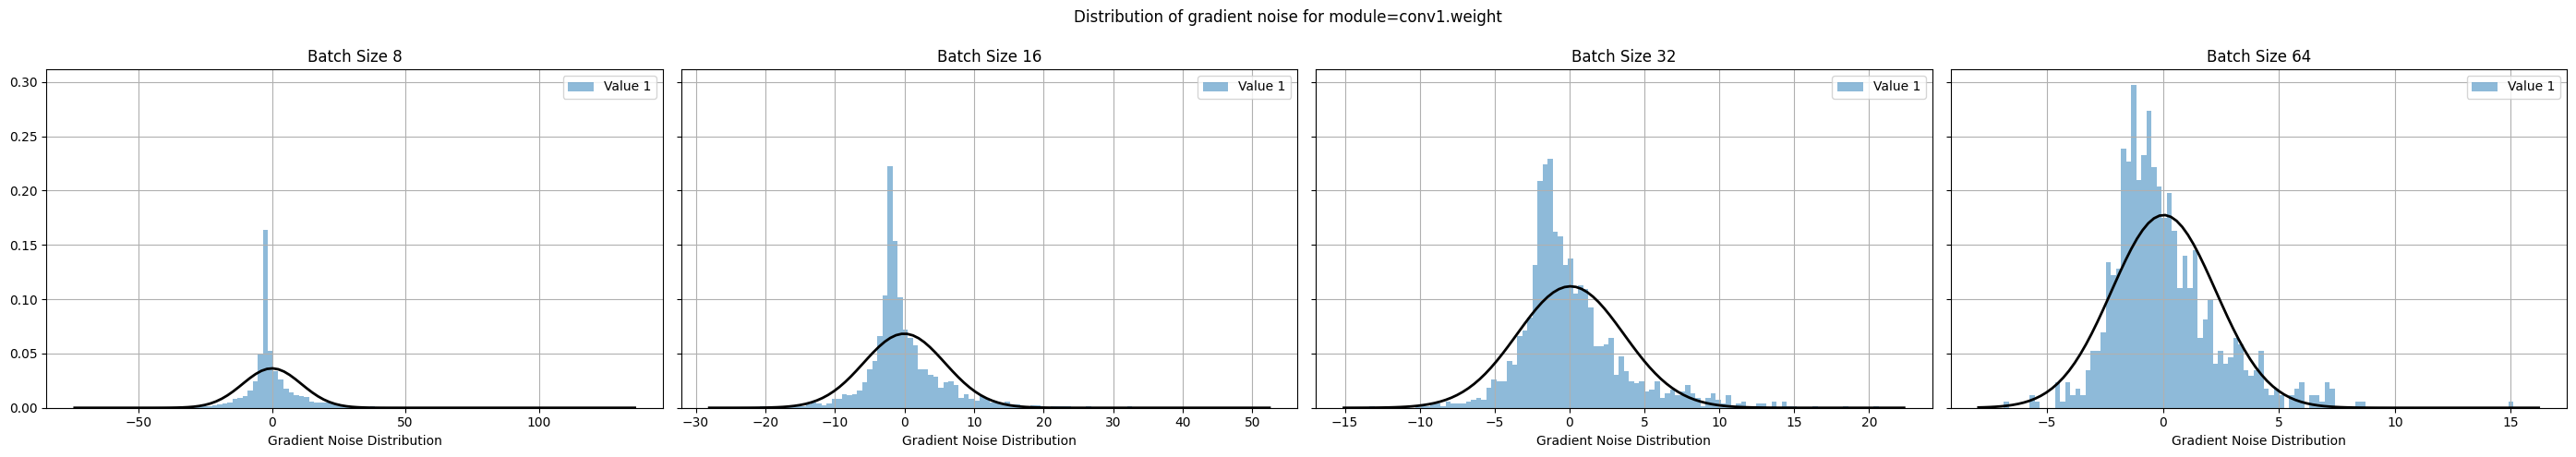

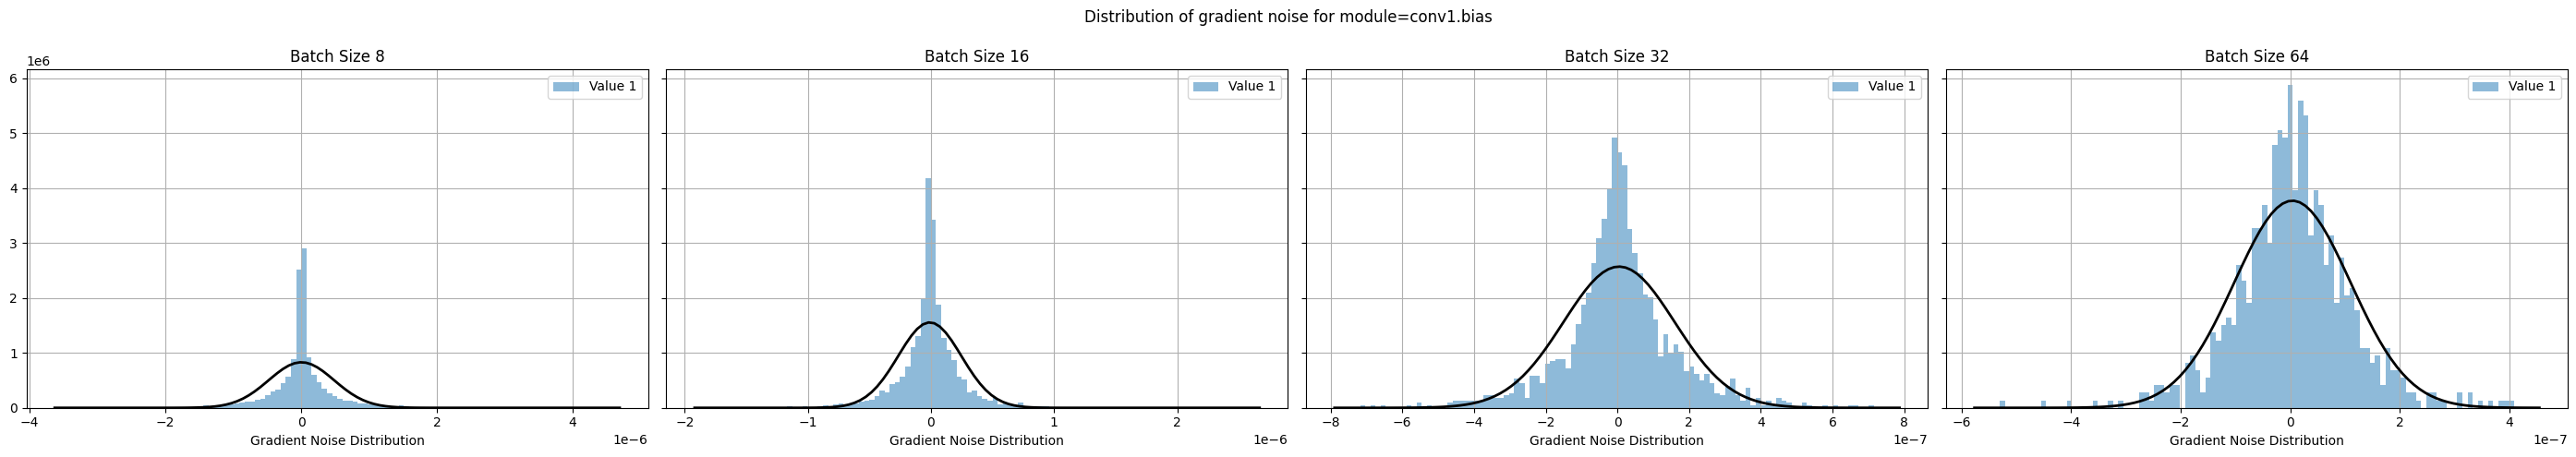

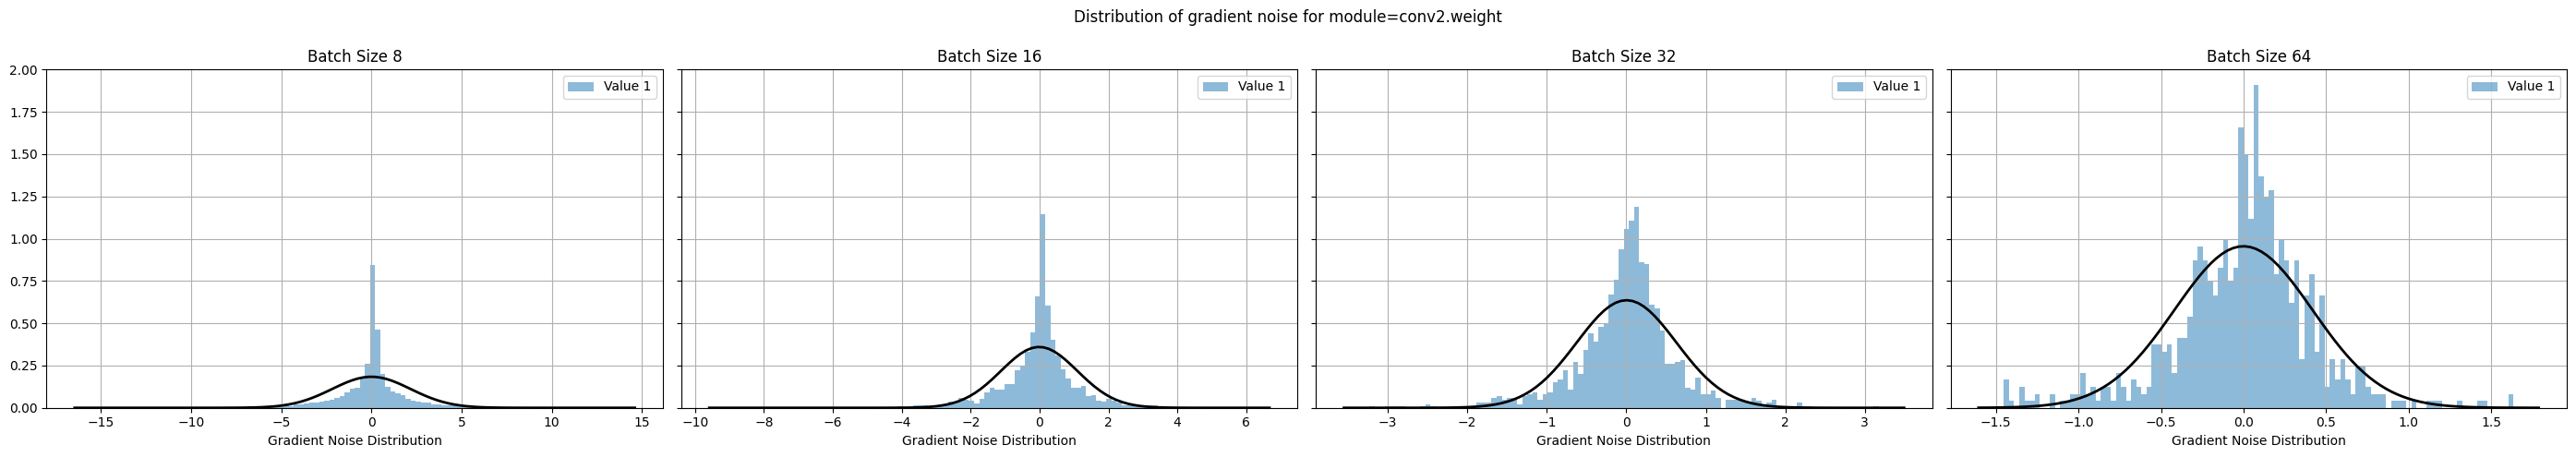

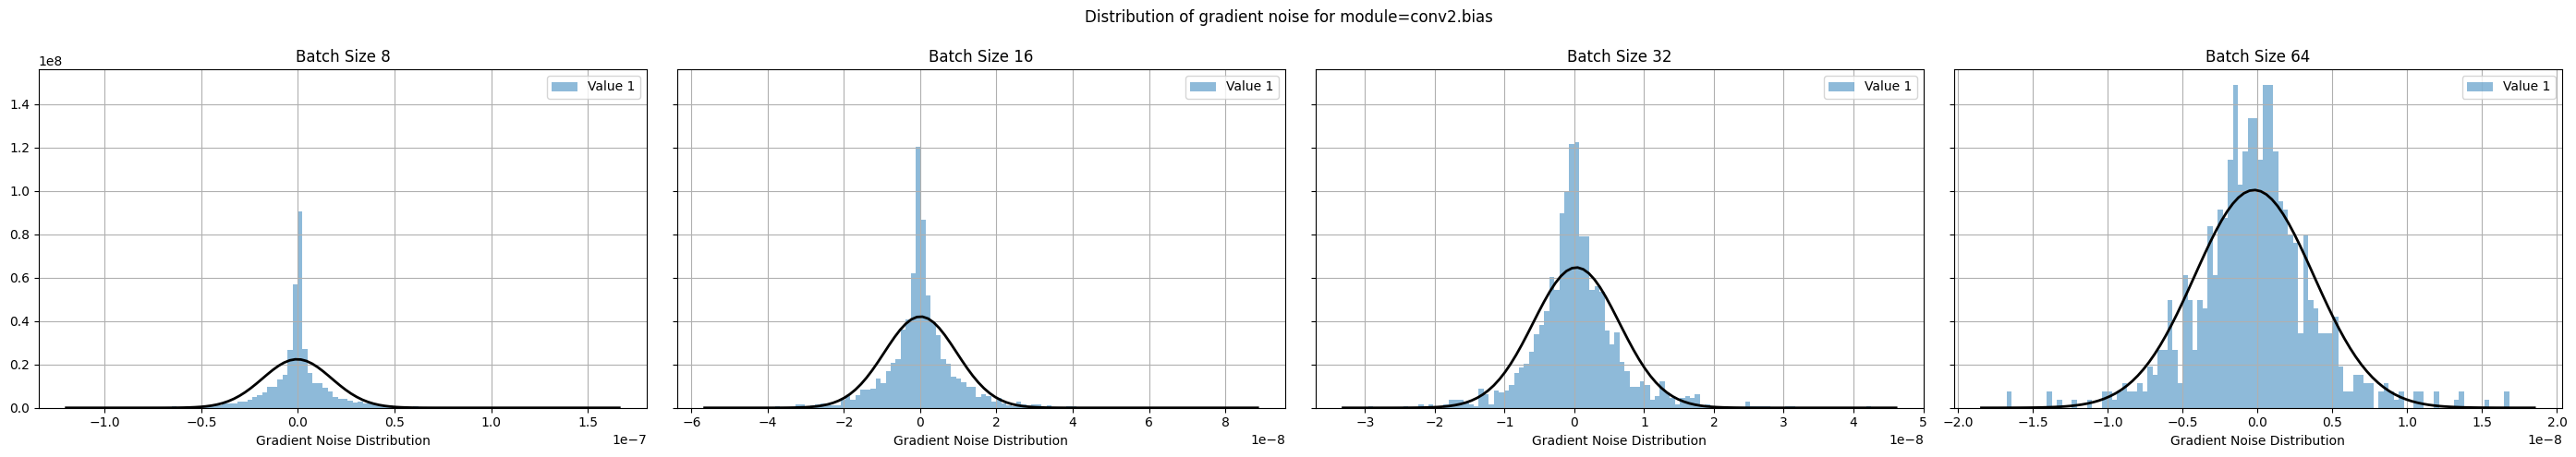

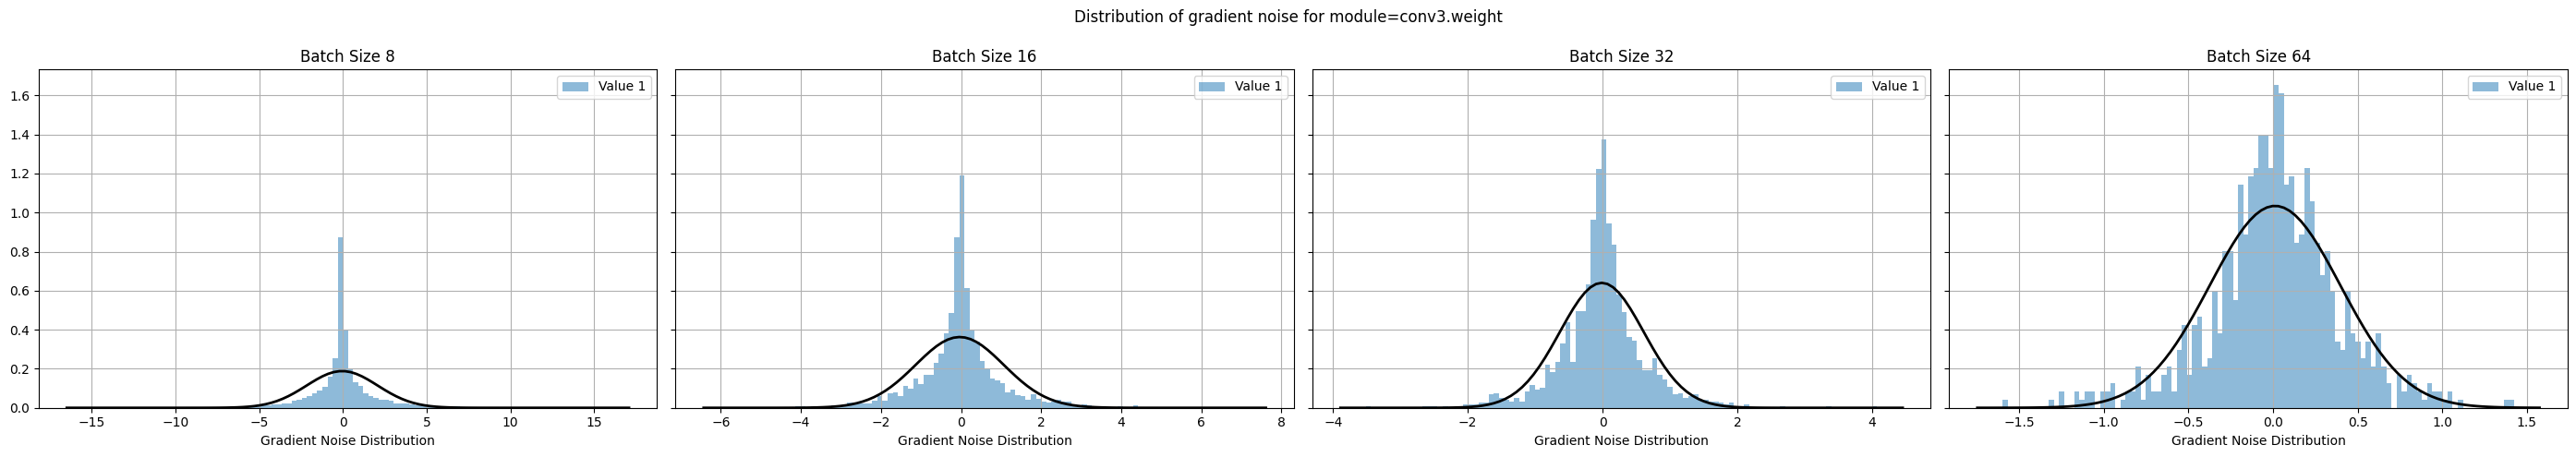

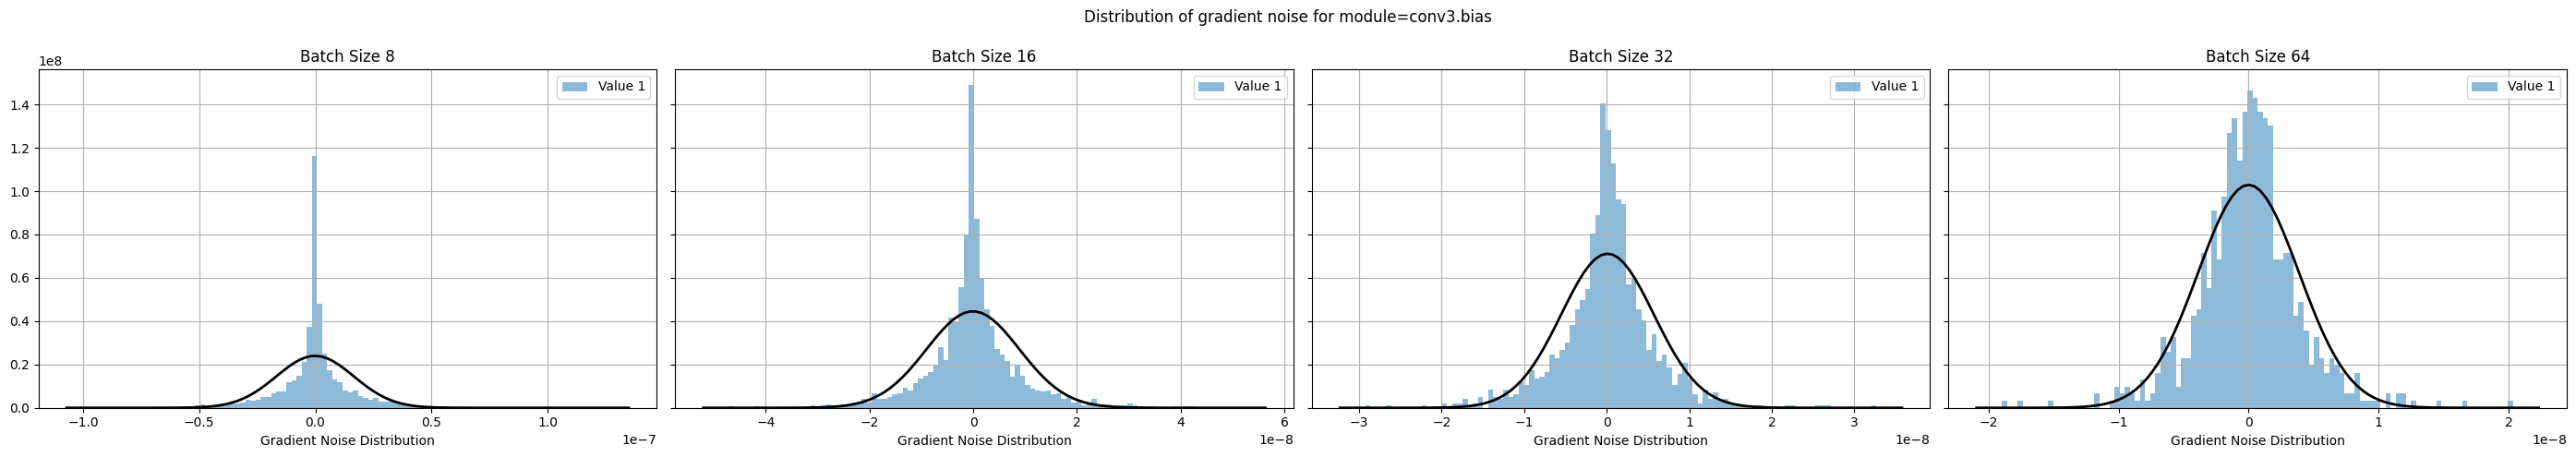

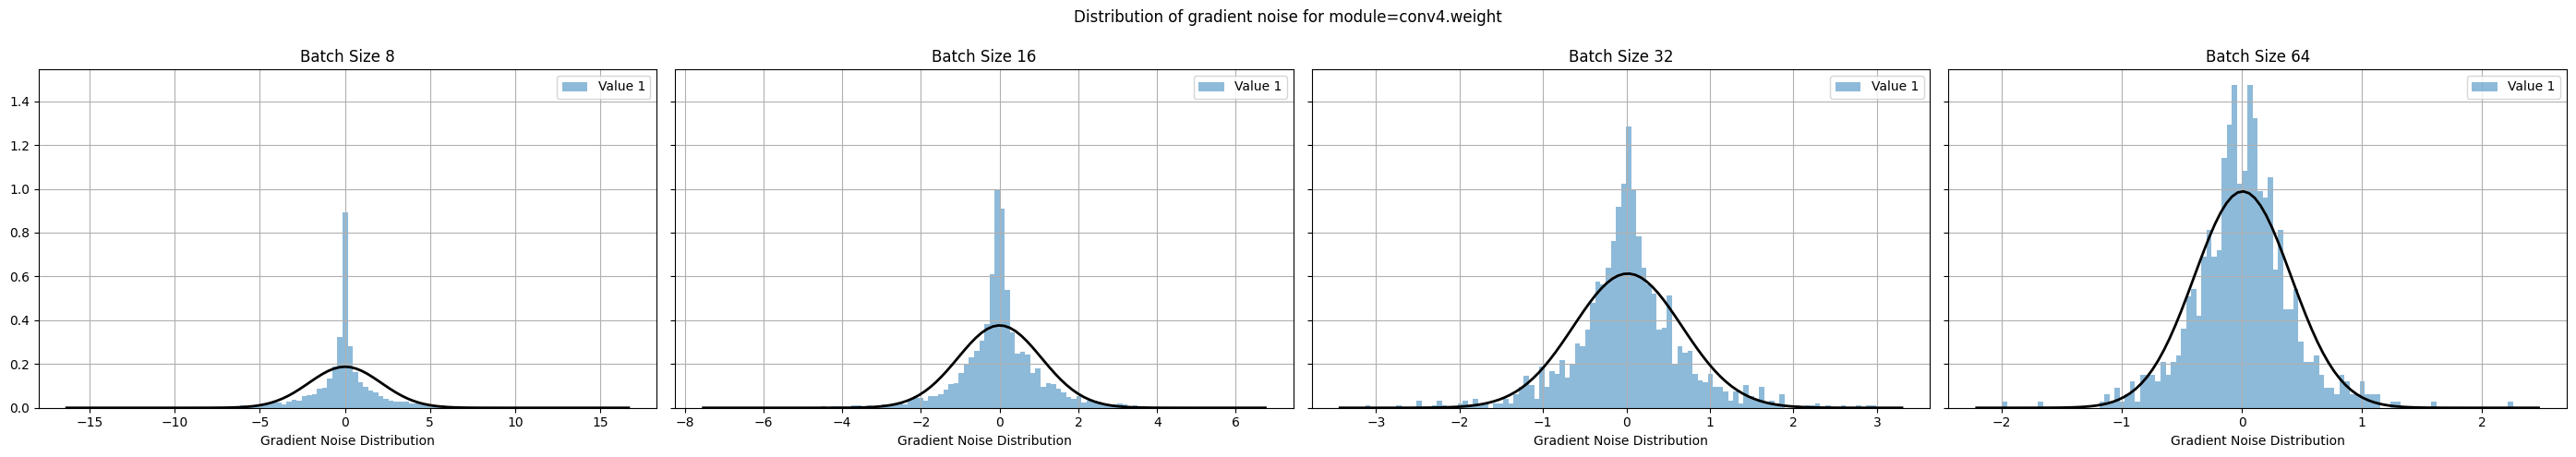

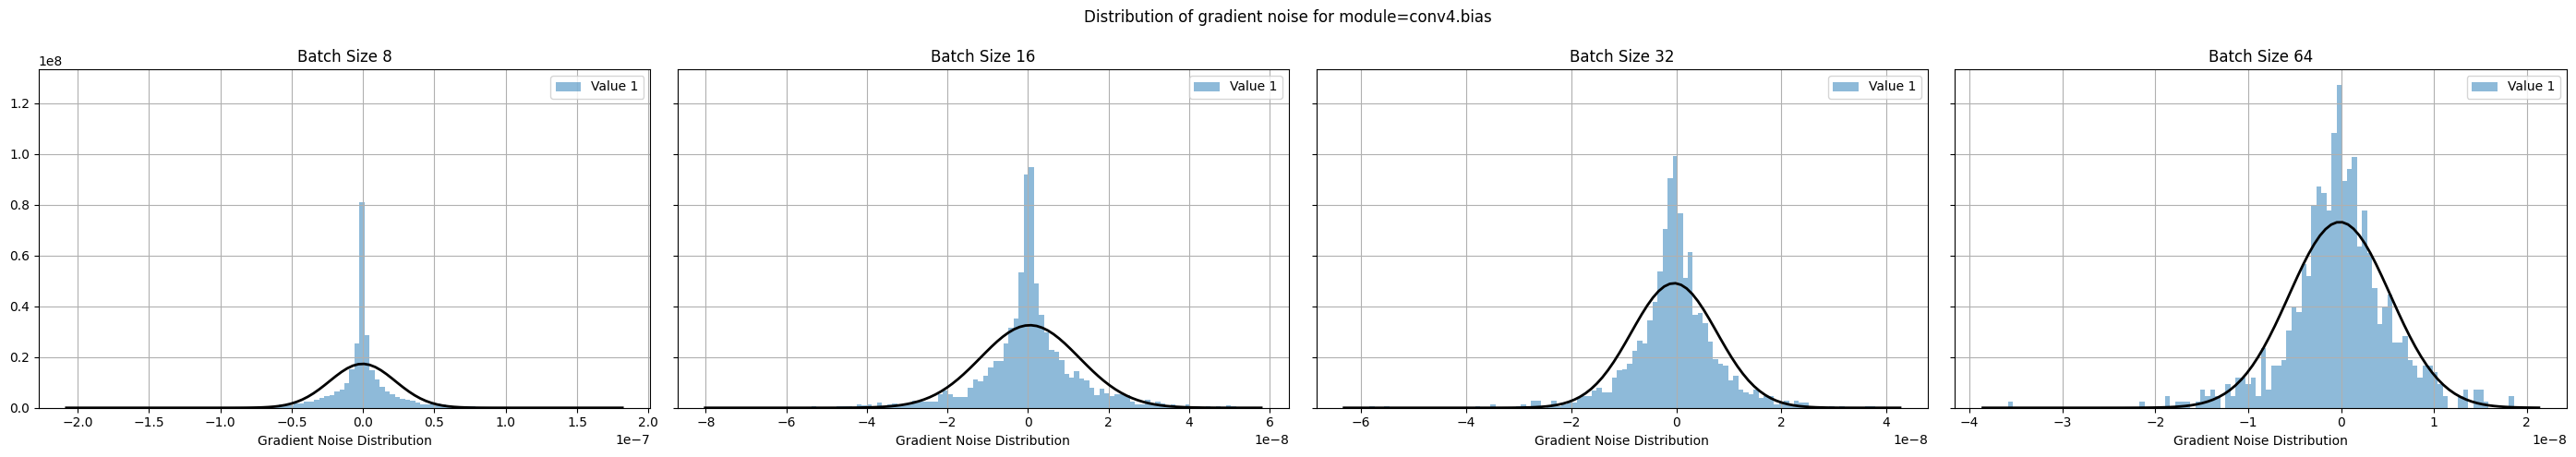

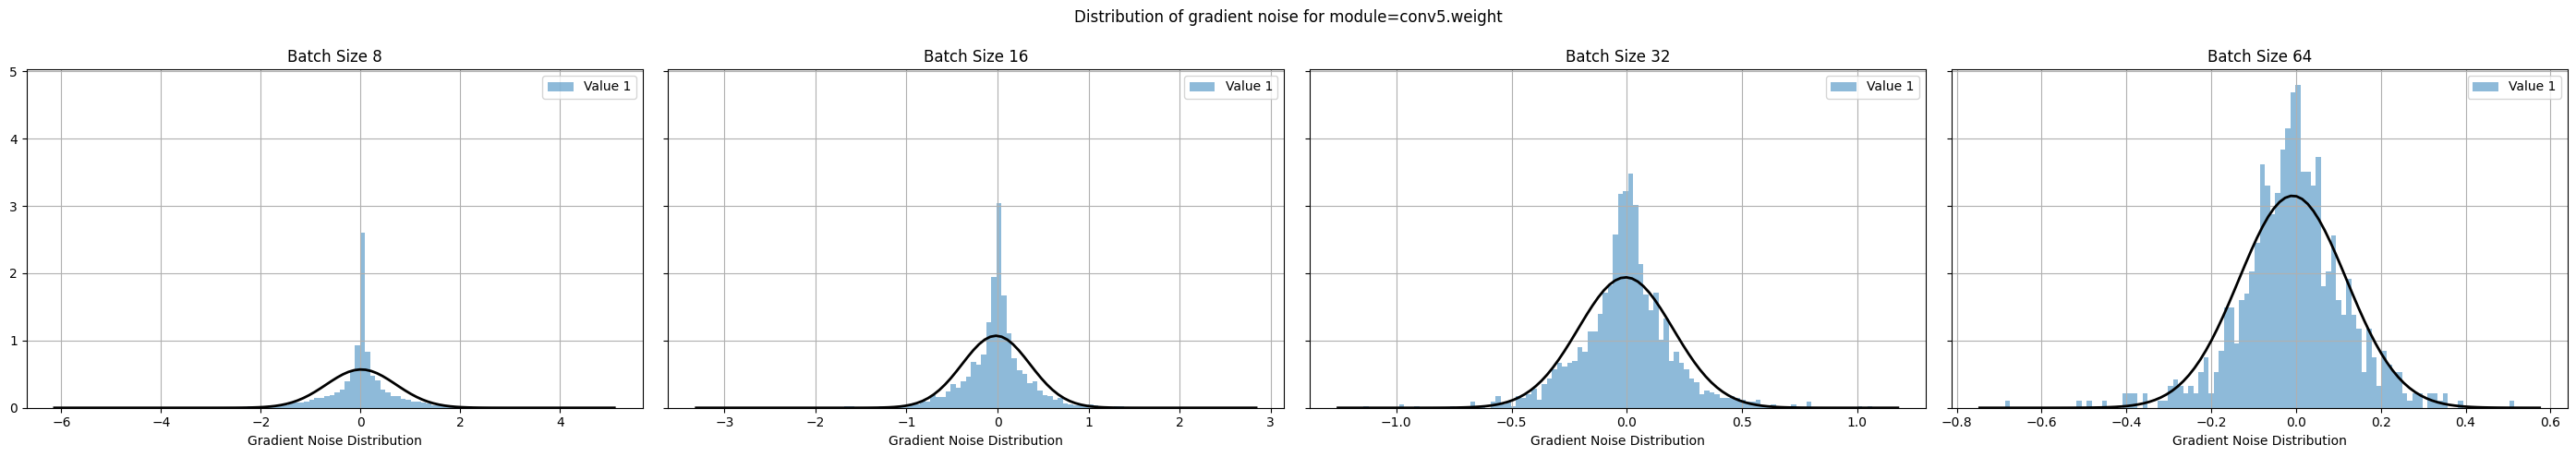

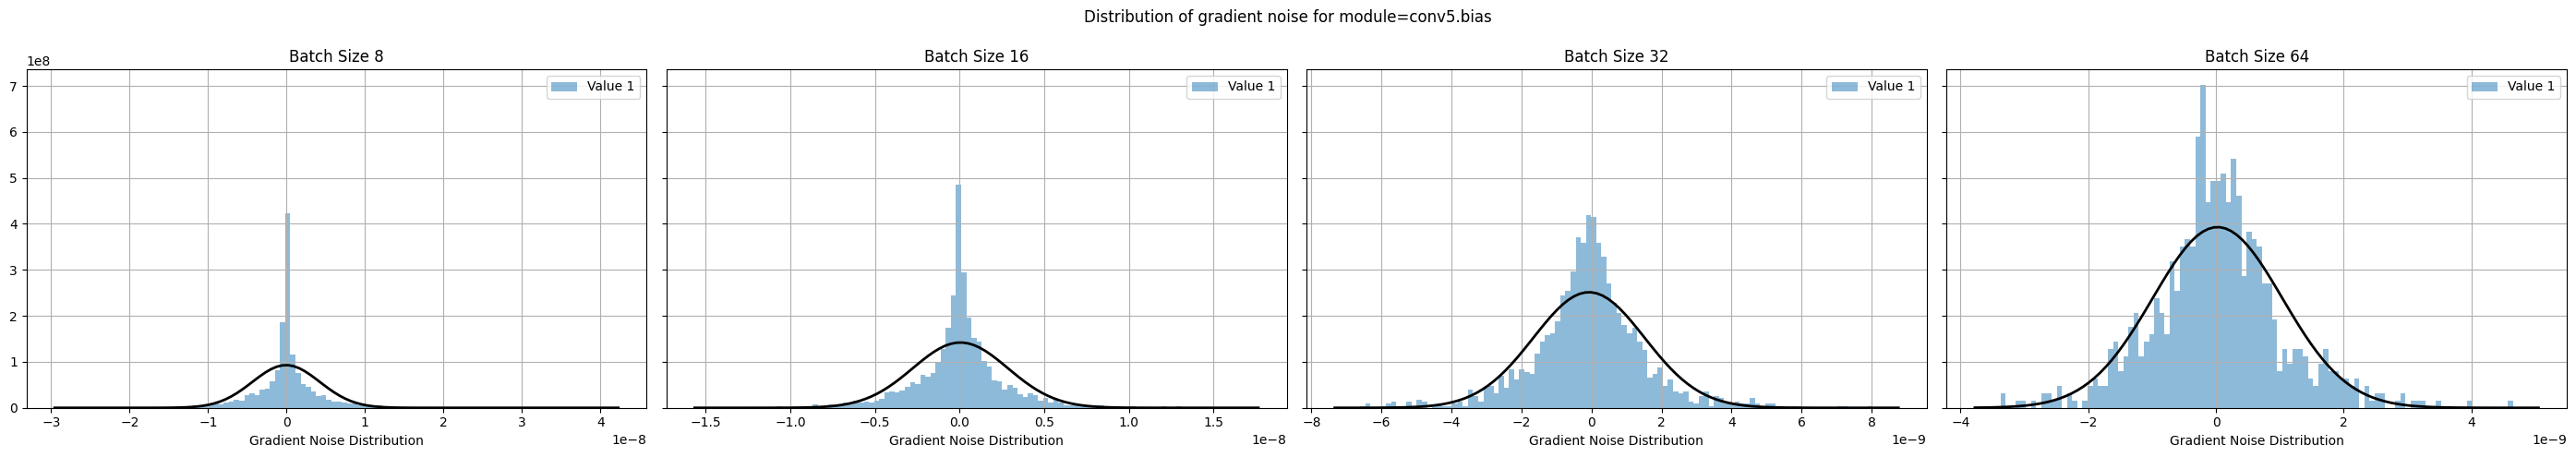

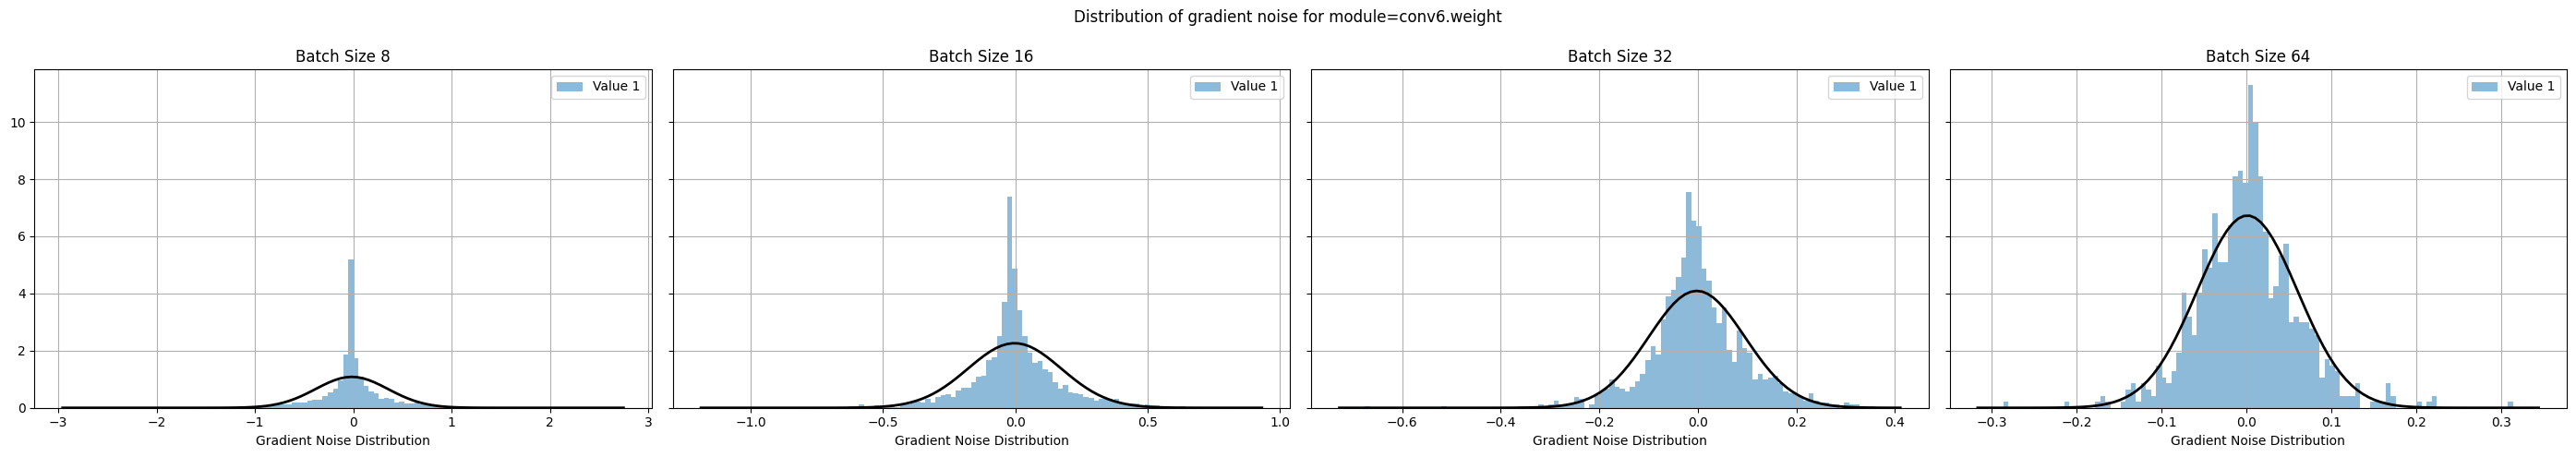

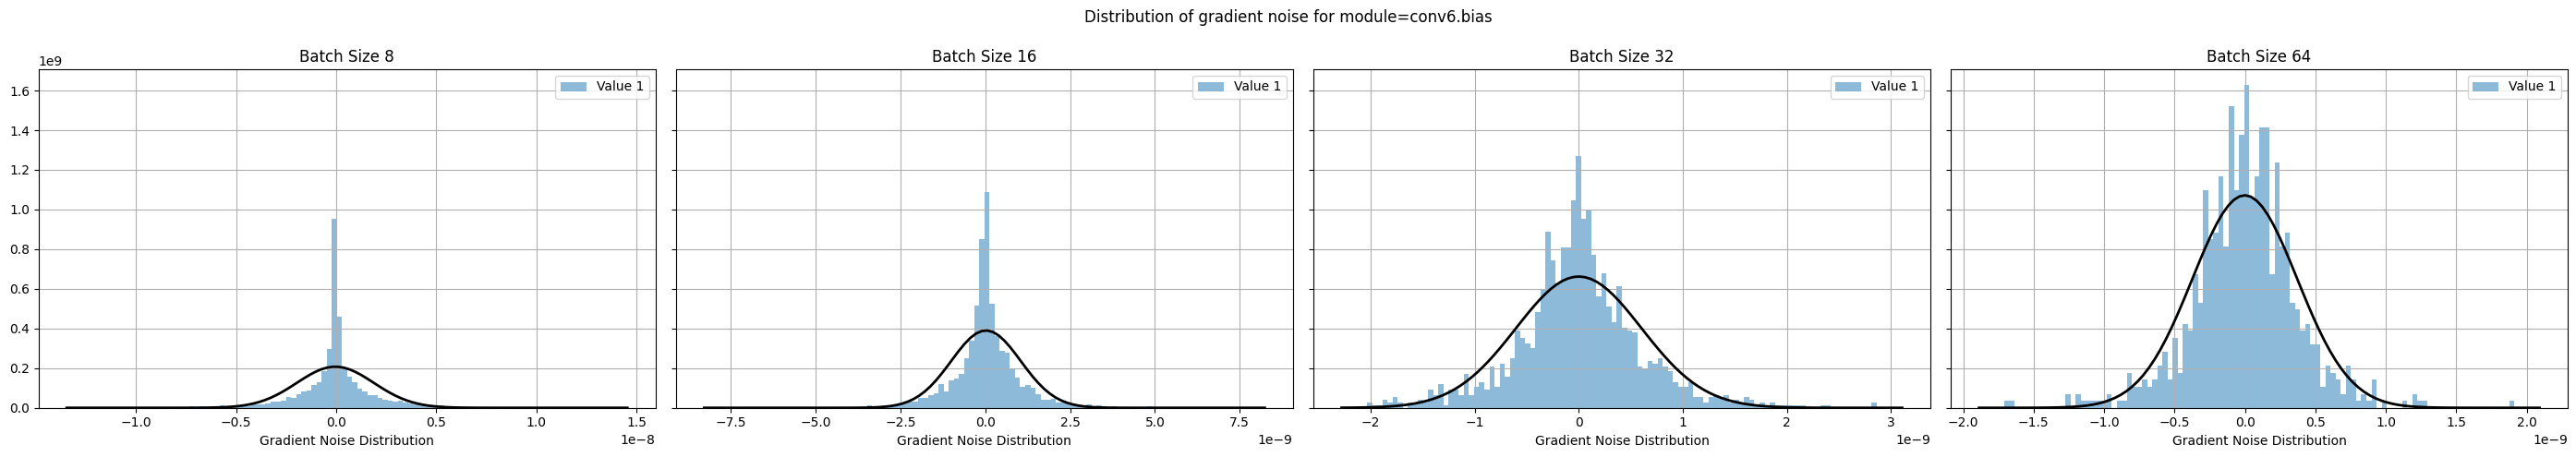

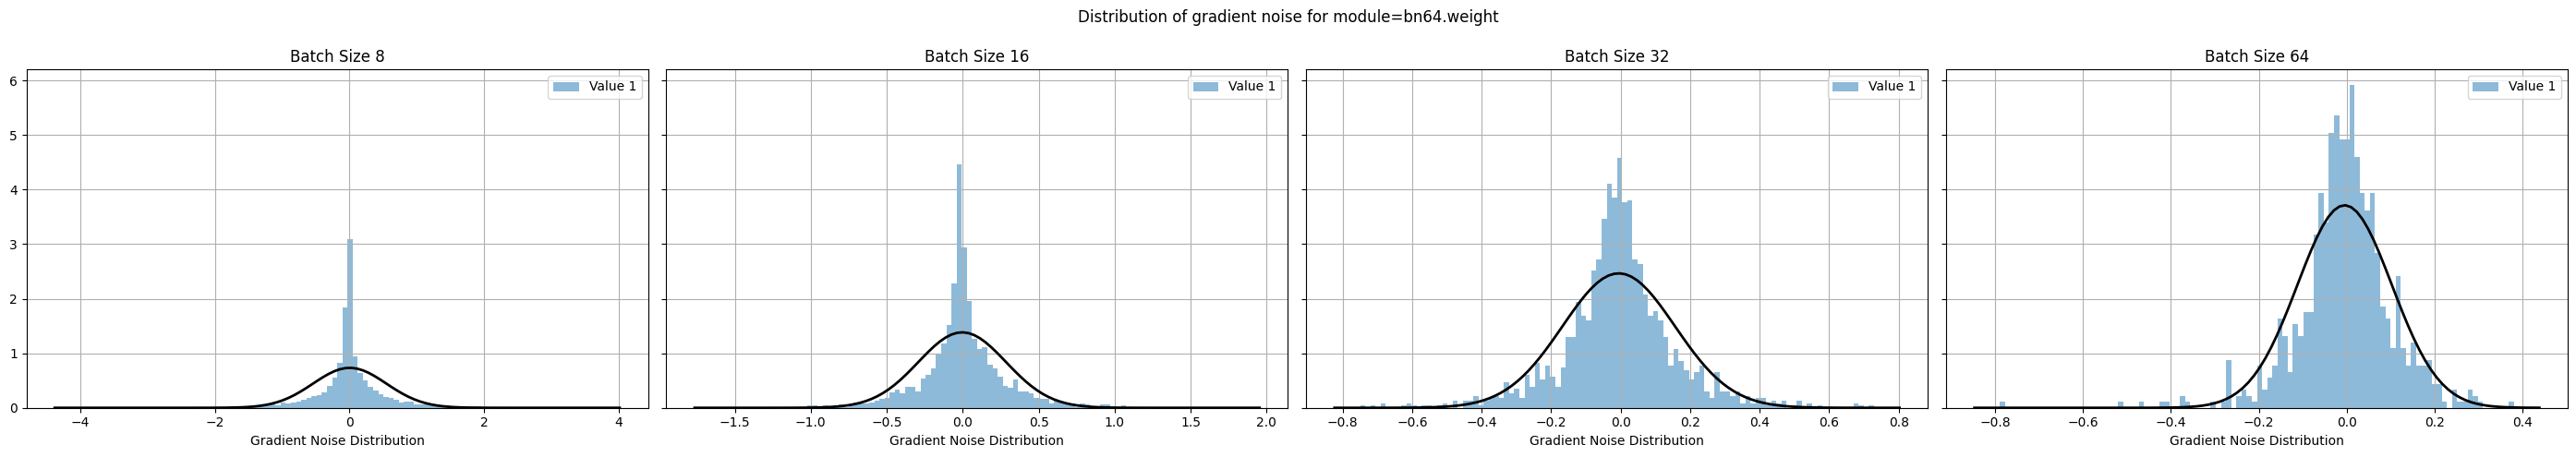

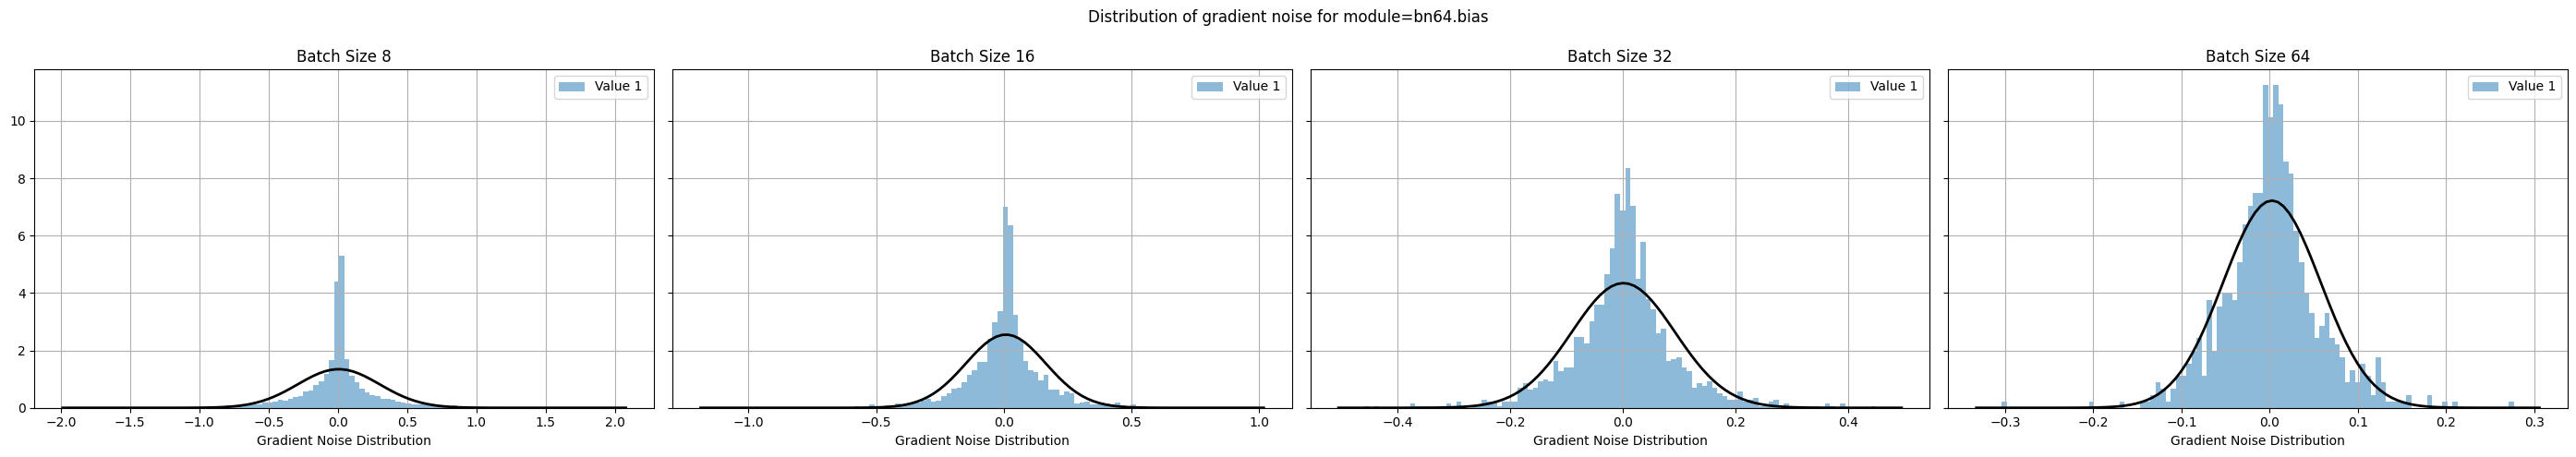

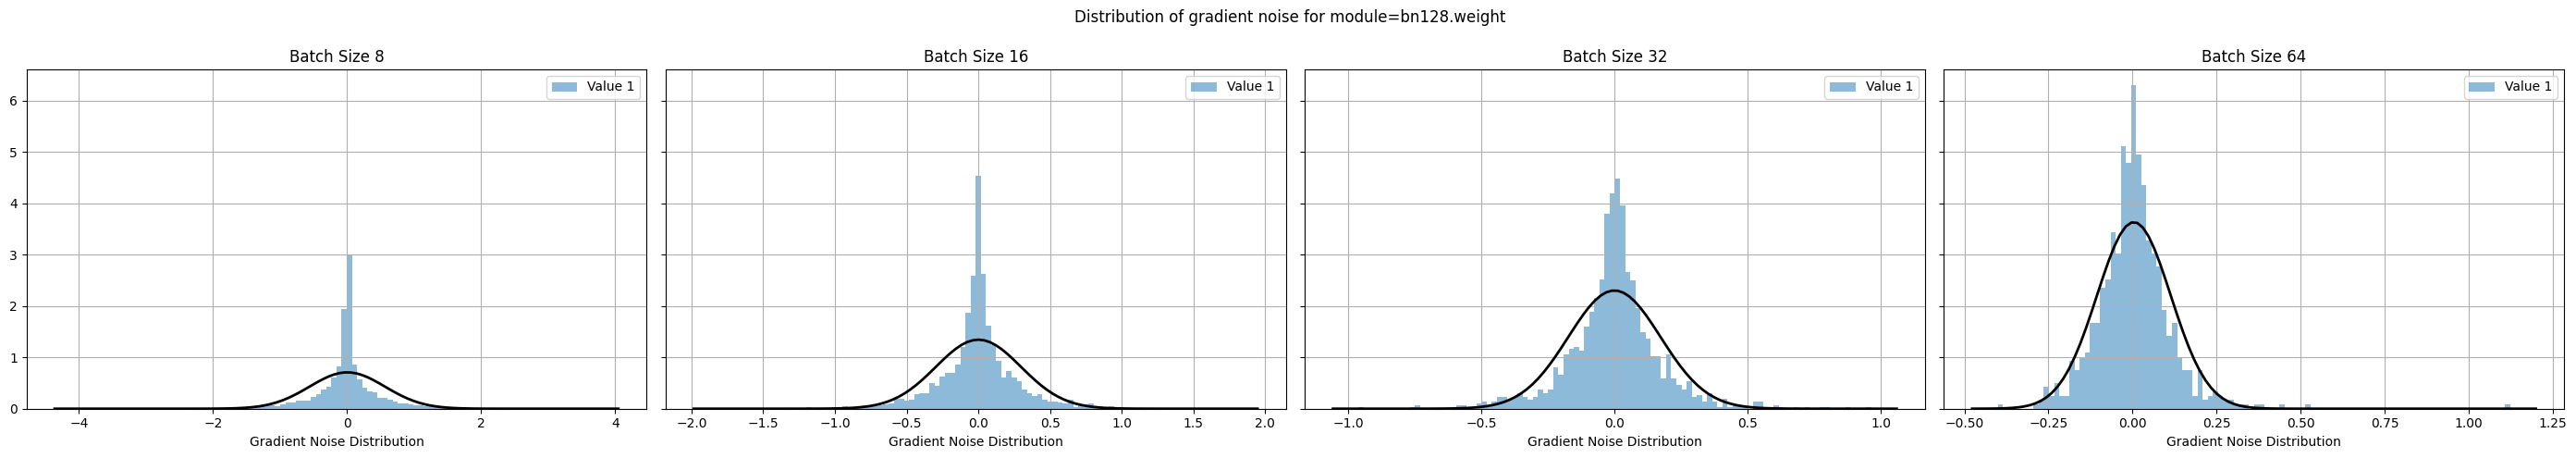

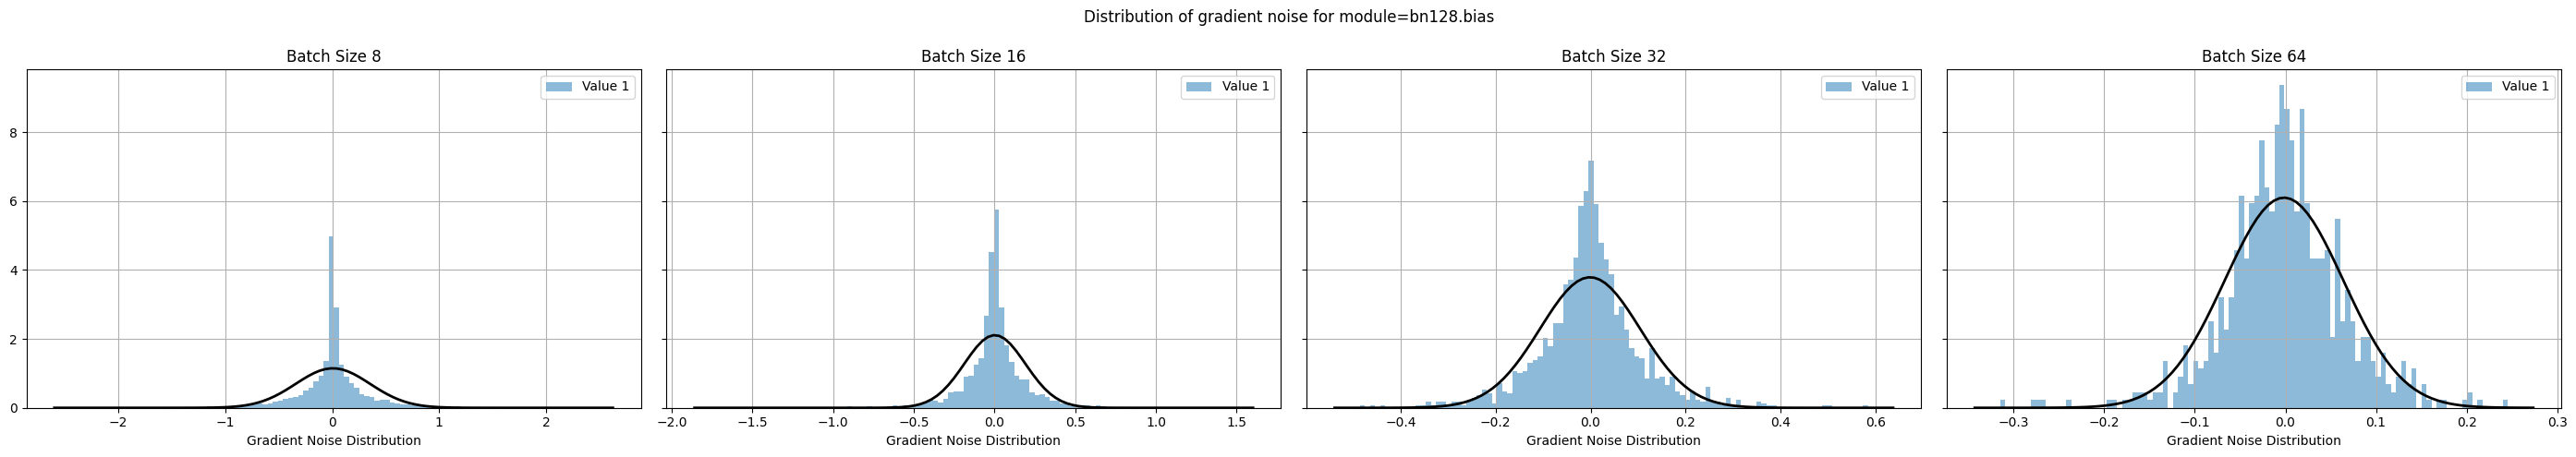

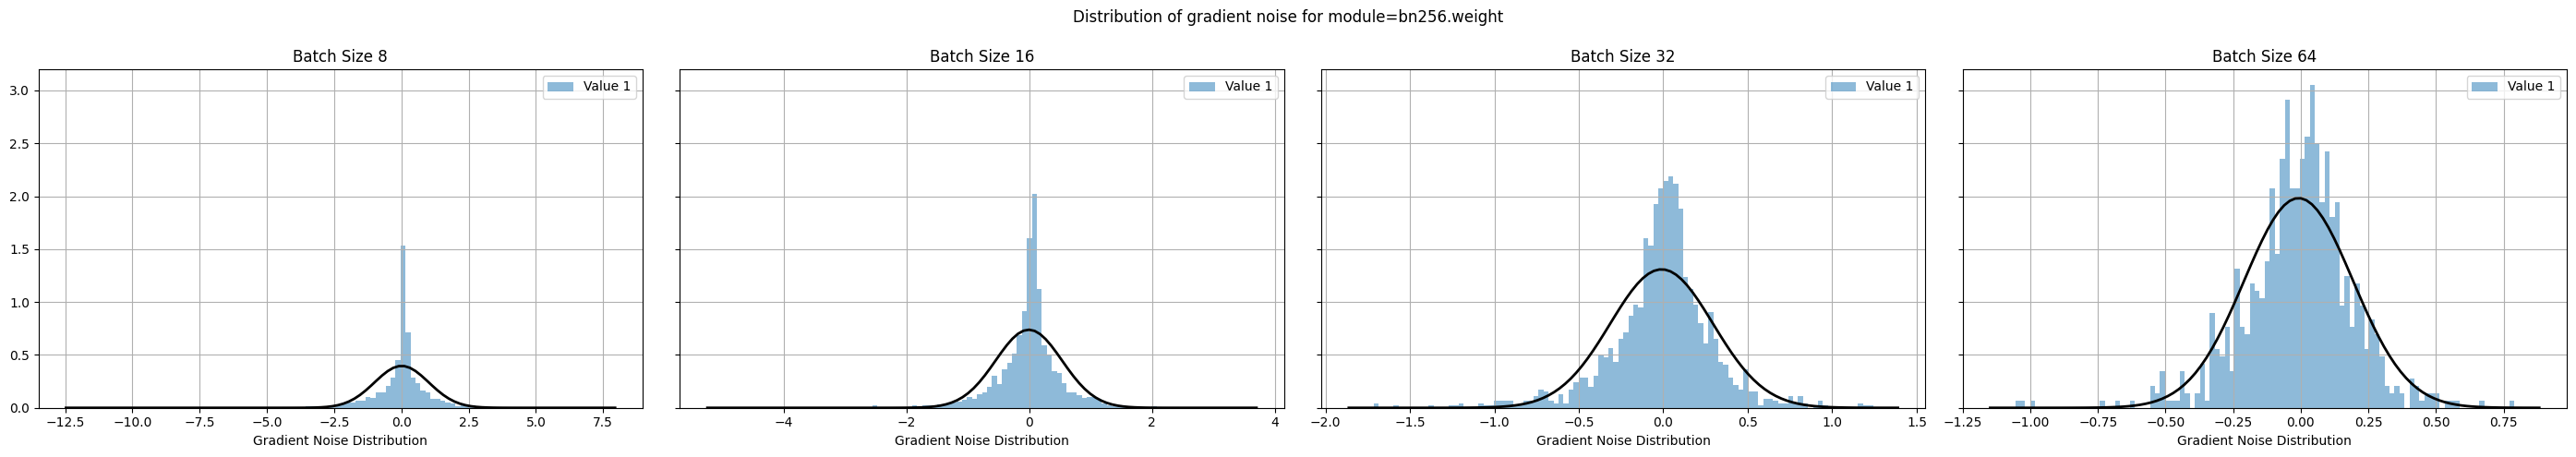

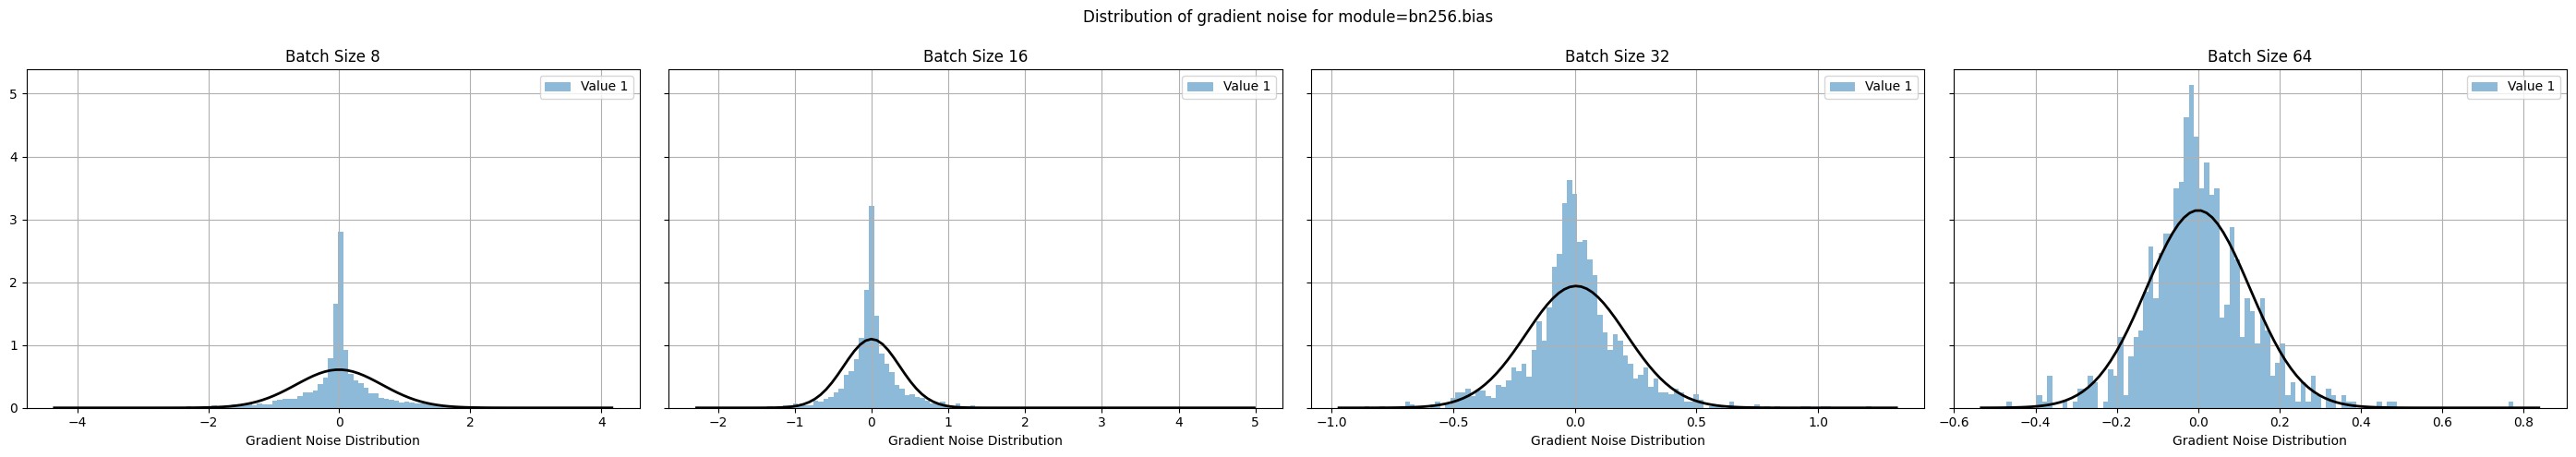

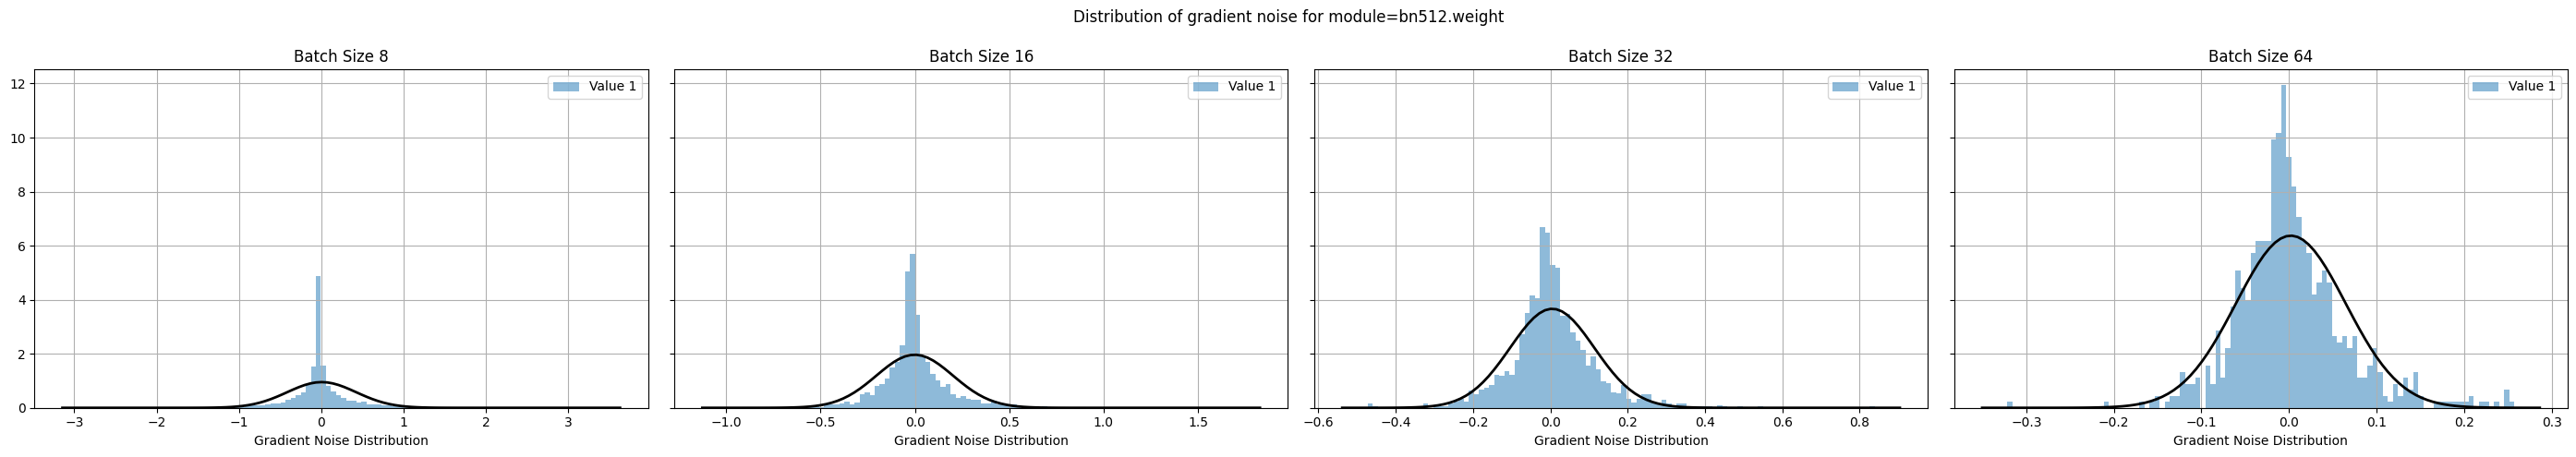

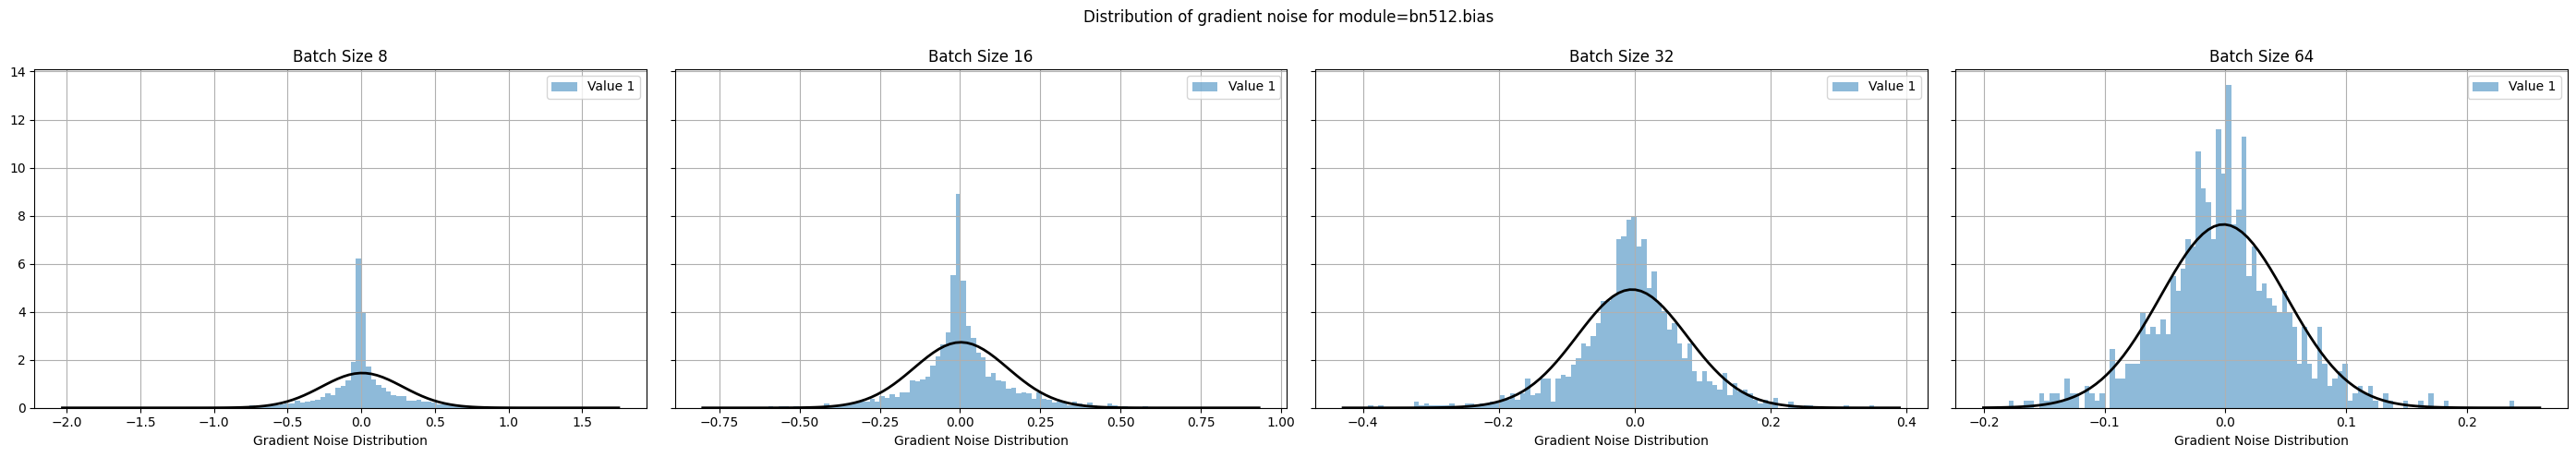

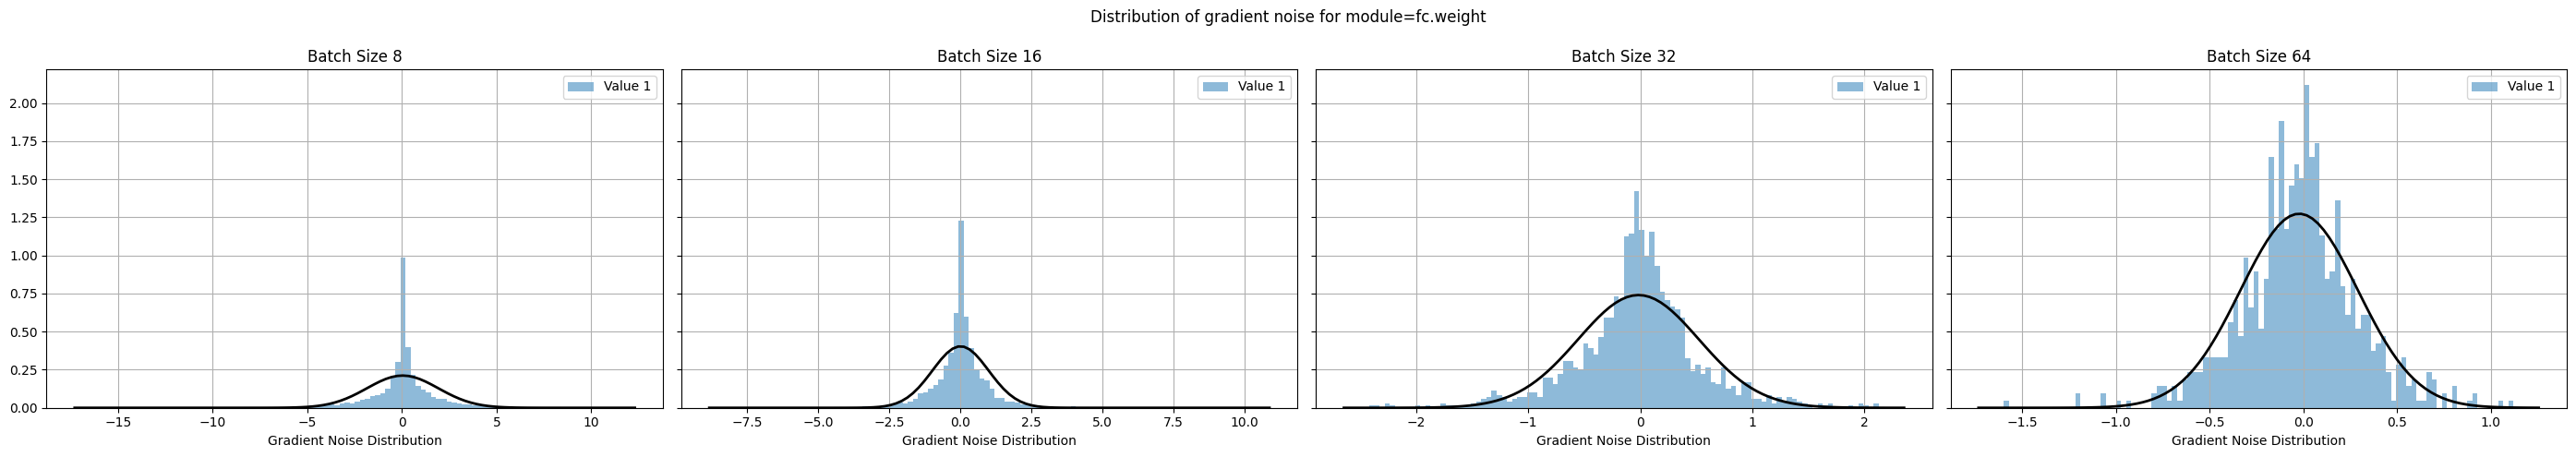

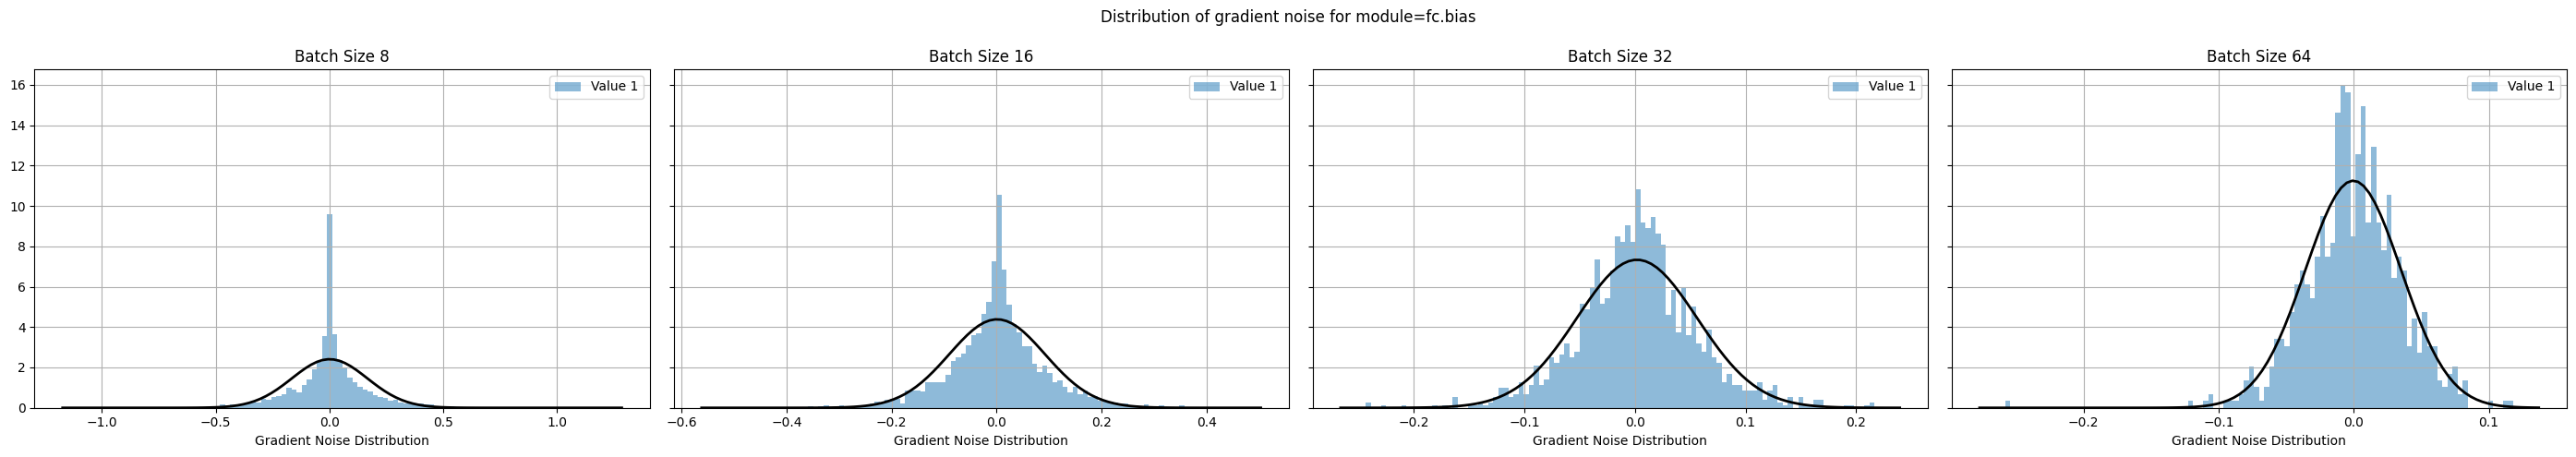

In [19]:
selected_indices = [0]

# Настройка подграфиков для каждого параметра модели
for key, _ in model.named_parameters():
    num_batches = len(batch_sizes[:4])  # Число батчей для отображения
    fig, axes = plt.subplots(1, num_batches, figsize=(7 * num_batches, 5), sharey=True)

    for i, batch_size in enumerate(batch_sizes[:4]):
        ax = axes[i] if num_batches > 1 else axes

        # Получаем одно значение из лога для определения размерности m
        sample_value = all_gradients_diff[batch_size][0][0][key]

        # Если значение является тензором, приводим его к numpy
        if isinstance(sample_value, torch.Tensor):
            sample_value = sample_value.cpu().numpy()

        # Определяем количество элементов в векторе (если скаляр — m = 1)
        m = sample_value.size if isinstance(sample_value, np.ndarray) else 1

        # Если выбраны индексы, но m = 1, сбрасываем их в [0]
        if m == 1:
            selected_indices = [0]

        for j in selected_indices:
            if j >= m:
                print(f"Skipping index {j} as it is out of bounds for tensor size {m}.")
                continue

            values_j = [v[key].cpu().numpy() if m == 1 else v[key][j].cpu().numpy() for v in all_gradients_diff[batch_size][0]]

            # Строим гистограмму
            ax.hist(values_j, bins=100, density=True, alpha=0.5, label=f'Value {j+1}')

            # Вычисляем параметры для гауссовского распределения
            mean, std = np.mean(values_j), np.std(values_j)
            xmin, xmax = ax.get_xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mean, std)
            ax.plot(x, p, 'k', linewidth=2)

        # Подписи и оформление
        ax.set_xlabel(r'Gradient Noise Distribution')
        ax.set_title(f'Batch Size {batch_size}')
        ax.grid(True)
        ax.legend()

    plt.suptitle(f'Distribution of gradient noise for module={key}')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
